# Lab 9

In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def load_TRTH_trade(filename,
             tz_exchange="America/New_York",
             only_non_special_trades=True,
             only_regular_trading_hours=True,
             open_time="09:30:00",
             close_time="16:00:00",
             merge_sub_trades=True):
    try:
        if re.search('(csv|csv\\.gz)$',filename):
            DF = pd.read_csv(filename)
        if re.search(r'arrow$',filename):
            DF = pd.read_arrow(filename)
        if re.search('parquet$',filename):
            DF = pd.read_parquet(filename)

    except Exception as e:
     #   print("load_TRTH_trade could not load "+filename)
     #   print(e)
        return None
    
    try:
        DF.shape
    except Exception as e: # DF does not exist
        print("DF does not exist")
        print(e)
        return None

    
    if DF.shape[0]==0:
        return None
    
    if only_non_special_trades:
        DF = DF[DF["trade-stringflag"]=="uncategorized"]

    DF.drop(columns=["trade-rawflag","trade-stringflag"],axis=1,inplace=True)
    
    DF.index = pd.to_datetime(DF["xltime"],unit="d",origin="1899-12-30",utc=True)
    DF.index = DF.index.tz_convert(tz_exchange)  # .P stands for Arca, which is based at New York
    DF.drop(columns="xltime",inplace=True)
    
    if only_regular_trading_hours:
        DF=DF.between_time(open_time,close_time)    # warning: ever heard e.g. about Thanksgivings?
    
    if merge_sub_trades:
           DF=DF.groupby(DF.index).agg(trade_price=pd.NamedAgg(column='trade-price', aggfunc='mean'),
                                       trade_volume=pd.NamedAgg(column='trade-volume', aggfunc='sum'))
    
    return DF


def load_TRTH_bbo(filename,
             tz_exchange="America/New_York",
             only_regular_trading_hours=True,
             merge_sub_trades=True):
    try:
        if re.search(r'(csv|csv\.gz)$',filename):
            DF = pd.read_csv(filename)
        if re.search(r'arrow$',filename):
            DF = pd.read_arrow(filename)
        if re.search(r'parquet$',filename):
            DF = pd.read_parquet(filename) 
    except Exception as e:
        print("load_TRTH_bbo could not load "+filename)
        return None
    
    try:
        DF.shape
    except Exception as e: # DF does not exist
        print("DF does not exist")
        print(e)
        return None

    if DF.shape[0]==0:
        return None
    
        
    DF.index = pd.to_datetime(DF["xltime"],unit="d",origin="1899-12-30",utc=True)
    DF.index = DF.index.tz_convert(tz_exchange)  # .P stands for Arca, which is based at New York
    DF.drop(columns="xltime",inplace=True)
    
    if only_regular_trading_hours:
        DF=DF.between_time("09:30:00","16:00:00")    # ever heard about Thanksgivings?
        
    if merge_sub_trades:
        DF=DF.groupby(DF.index).last()
    

        
    return DF

In [3]:
def load_merge_trade_bbo(ticker,date,
                         country="US",
                         dirBase="../data/raw/TRTH/equities/",
                         suffix="parquet",
                         suffix_save=None,
                         dirSaveBase="../data/clean/TRTH/equities/events",
                         saveOnly=False,
                         doSave=False
                        ):
    
    file_trade=dirBase+"/"+country+"/trade/"+ticker+"/"+str(date.date())+"-"+ticker+"-trade."+suffix
    file_bbo=file_trade.replace("trade","bbo")
    trades=load_TRTH_trade(file_trade)
    bbos  =load_TRTH_bbo(file_bbo)
    try:
        trades.shape + bbos.shape
    except:
        return None
    
    events=trades.join(bbos,how="outer")
    
    if doSave:
        dirSave=dirSaveBase+"/"+country+"/events/"+ticker
        if not os.path.isdir(dirSave):
            os.makedirs(dirSave)

        if suffix_save:
            suffix=suffix_save
        
        file_events=dirSave+"/"+str(date.date())+"-"+ticker+"-events"+"."+suffix
       # pdb.set_trace()

        saved=False
        if suffix=="arrow":
            events=vaex.from_pandas(events,copy_index=True)
            events.export_arrow(file_events)
            saved=True
        if suffix=="parquet":
         #   pdb.set_trace()
            events.to_parquet(file_events,use_deprecated_int96_timestamps=True)
            saved=True
            
        if not saved:
            print("suffix "+suffix+" : format not recognized")
            
        if saveOnly:
            return saved
    return events

In [27]:
data_lmt = pd.read_parquet("../data/raw/TRTH/equities/US/bbo/LMT.N/2004-01-02-LMT.N-bbo.parquet", engine="pyarrow")
data_lmt["xltime"] = np.round(data_lmt["xltime"].astype("float64"), 4)
data_lmt["mid-price"] = (data_lmt["bid-price"] + data_lmt["ask-price"]) / 2
data_lmt["mid-price-return"] = data_lmt["mid-price"].pct_change()
data_lmt = data_lmt[data_lmt["mid-price-return"] > 0]

data_gs = pd.read_parquet("../data/raw/TRTH/equities/US/bbo/GS.N/2004-01-02-GS.N-bbo.parquet", engine="pyarrow")
data_gs["xltime"] = np.round(data_gs["xltime"].astype("float64"), 4)
data_gs["mid-price"] = (data_gs["bid-price"] + data_gs["ask-price"]) / 2
data_gs["mid-price-return"] = data_gs["mid-price"].pct_change()
data_gs = data_gs[data_gs["mid-price-return"] > 0]

merged = pd.merge(data_lmt, data_gs, on="xltime", how="outer", suffixes=("_lmt", "_gs"))
merged.ffill(inplace=True)
merged.dropna(inplace=True)
display(merged)
std_lmt = merged["mid-price-return_lmt"].std()
std_gs = merged["mid-price-return_gs"].std()
cov = (merged["mid-price-return_lmt"]*merged["mid-price-return_gs"]).mean()
corr = cov/(std_lmt*std_gs)
print(cov, corr)

,xltime,bid-price_lmt,bid-volume_lmt,ask-price_lmt,ask-volume_lmt,mid-price_lmt,mid-price-return_lmt,bid-price_gs,bid-volume_gs,ask-price_gs,ask-volume_gs,mid-price_gs,mid-price-return_gs
11,37988.6068,51.33,4.0,51.36,3.0,51.345,0.000195,99.01,5.0,99.04,9.0,99.025,0.000354
12,37988.6068,51.33,4.0,51.36,3.0,51.345,0.000195,98.96,4.0,99.04,9.0,99.000,0.000051
13,37988.6068,51.33,4.0,51.36,3.0,51.345,0.000195,99.01,4.0,99.04,9.0,99.025,0.000253
14,37988.6068,51.33,4.0,51.36,3.0,51.345,0.000195,99.02,3.0,99.04,9.0,99.030,0.000303
15,37988.6068,51.34,1.0,51.36,5.0,51.350,0.000390,99.01,5.0,99.04,9.0,99.025,0.000354
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2699,37988.8745,50.68,23.0,50.71,109.0,50.695,0.000099,97.16,54.0,97.18,12.0,97.170,0.000051
2700,37988.8747,50.68,23.0,50.71,109.0,50.695,0.000099,97.13,1.0,97.17,10.0,97.150,0.000051
2701,37988.8747,50.68,23.0,50.71,109.0,50.695,0.000099,97.13,1.0,97.16,10.0,97.145,0.000051
2702,37988.8747,50.68,23.0,50.71,109.0,50.695,0.000099,97.13,1.0,97.18,8.0,97.155,0.000103


1.3340702250791879e-08 1.275231033738025


/Users/macos/Financial-Big-Data/.venv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Axes: ylabel='Density'>

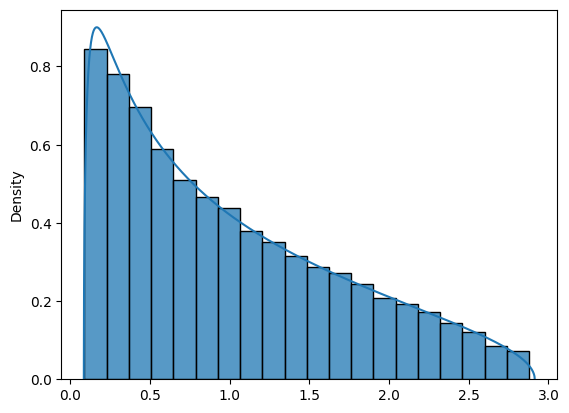

In [30]:
N, T, sigma = 1000, 2000, 1

random_returns = pd.DataFrame(np.random.normal(0, sigma, (N, T)))

corr_rand = np.corrcoef(random_returns)

eig, _ = np.linalg.eig(corr_rand)
sns.histplot(eig, bins=20, stat="density")

def marcenko_pastur(x, N, T):
    q = N/T
    a = (1 + np.sqrt(q))**2
    b = (1 - np.sqrt(q))**2
    mp = (np.sqrt((a-x)*(x-b)))/(2*np.pi*q*x)
    return b, a, mp

a, b, _ = marcenko_pastur(N/T, N, T)
x = np.linspace(a, b, T)
y = marcenko_pastur(x, N, T)[2]
sns.lineplot(x, y)

In [6]:
def eigenvalue_clip(data):
    T, N = data.shape
    eig, eig_vec = np.linalg.eig(data)
    lambda_p = (1 + np.sqrt(N/T))**2
    clip = eig > lambda_p
    N_clip = N - np.sum(clip)
    sum_lambda = np.sum(eig[clip])
    delta = (N - sum_lambda)/N_clip
    eig[np.logical_not(clip)] = delta
    C = eig_vec.T @ np.diag(eig) @ eig_vec
    C = C - np.diag(np.diag(C)) + np.eye(N)
    return C

In [10]:
clipped = eigenvalue_clip(np.corrcoef(random_returns))

<Axes: >

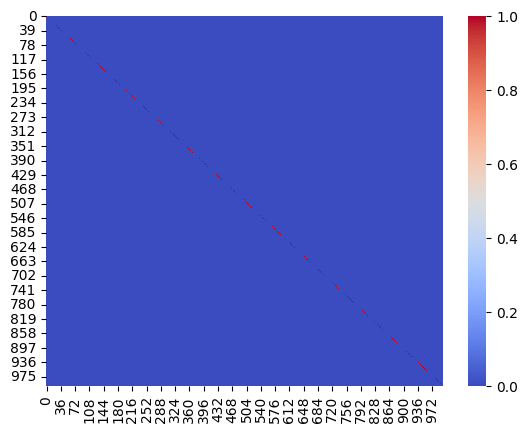

In [12]:
sns.heatmap(clipped, cmap="coolwarm")